# **Imports**

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, SimpleRNN, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers
from keras.utils.vis_utils import plot_model

## Reading Data

In [2]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

In [3]:
train='../input/nslkdd/KDDTrain+.txt'
test='../input/nslkdd/KDDTest+.txt'
train_data=pd.read_csv(train,names=feature)
test_data=pd.read_csv(test,names=feature)
data= pd.concat([train_data, test_data], ignore_index=True)

In [4]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148513,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148514,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15
148515,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [5]:
# remove attribute 'difficulty_level'
data.drop(['difficulty'],axis=1,inplace=True)

## Exploring Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,148517.0,276.779305,2.460683e+03,0.0,0.00,0.00,0.00,5.771500e+04
src_bytes,148517.0,40227.949299,5.409612e+06,0.0,0.00,44.00,278.00,1.379964e+09
dst_bytes,148517.0,17088.853593,3.703525e+06,0.0,0.00,0.00,571.00,1.309937e+09
land,148517.0,0.000215,1.467714e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,148517.0,0.020523,2.400691e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,148517.0,0.000202,1.941708e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,148517.0,0.189379,2.013160e+00,0.0,0.00,0.00,0.00,1.010000e+02
num_failed_logins,148517.0,0.004323,7.224823e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,148517.0,0.402789,4.904606e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,148517.0,0.255062,2.223137e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [8]:
# number of attack labels 
data['label'].value_counts()

normal             77054
neptune            45871
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm               2


In [9]:
# Redistribute across common attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [10]:
change_label(data)
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [11]:
# distribution of attack classes
data.label.value_counts()

normal    77054
Dos       53387
Probe     14077
R2L        3880
U2R         119
Name: label, dtype: int64

### Protocol

In [12]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(data.label)
label

,label
0,normal
1,normal
2,Dos
3,normal
4,normal
...,...
148512,normal
148513,normal
148514,Dos
148515,normal


In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalization(df, col):
  """Normalizes the specified columns in a DataFrame to a range of 0 to 1."""
  scaler = MinMaxScaler()  # Use MinMaxScaler for normalization
  for i in col:
    arr = df[i].values.reshape(-1, 1)
    df[i] = scaler.fit_transform(arr)
  return df

# Example usage (assuming you have a DataFrame named 'data'):
numeric_col = data.select_dtypes(include='number').columns
data = normalization(data.copy(), numeric_col)  # Use a copy to avoid modifying original data


In [14]:
# from sklearn.preprocessing import StandardScaler

# # Using StandardScaler for normalization
# std_scaler = StandardScaler()

# def standardization(df, col):
#     for i in col:
#         arr = df[i].values.reshape(-1, 1)
#         df[i] = std_scaler.fit_transform(arr)
#     return df

# # Selecting numeric columns
# numeric_col = data.select_dtypes(include='number').columns

# # Applying standardization to the numeric columns
# data = standardization(data, numeric_col)


In [15]:
from sklearn import preprocessing

# Label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()

# Convert the 'label' column to string type
label = label.astype(str)

# Apply label encoding
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label

print(data.shape)
data


(148517, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,0.0,tcp,ftp_data,SF,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,4
1,0.0,udp,other,SF,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,4
2,0.0,tcp,private,S0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos,0
3,0.0,tcp,http,SF,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,4
4,0.0,tcp,http,SF,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0.0,tcp,smtp,SF,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,...,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,4
148513,0.0,tcp,http,SF,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,...,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,4
148514,0.0,tcp,http,SF,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,...,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,Dos,0
148515,0.0,udp,domain_u,SF,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,...,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,4


In [16]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data

(148517, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,0.0,tcp,ftp_data,SF,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,4
1,0.0,udp,other,SF,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,4
2,0.0,tcp,private,S0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos,0
3,0.0,tcp,http,SF,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,4
4,0.0,tcp,http,SF,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0.0,tcp,smtp,SF,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,...,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,4
148513,0.0,tcp,http,SF,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,...,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,4
148514,0.0,tcp,http,SF,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,...,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,Dos,0
148515,0.0,udp,domain_u,SF,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,...,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,4


In [17]:
data.drop(labels= ['label'], axis=1, inplace=True)
print(data.shape)


(148517, 42)


In [18]:
# one-hot-encoding categorical columns
data = pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
print(data.shape)

(148517, 123)


In [19]:
y_data= data['intrusion']
X_data= data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

X_train has shape: (148517, 122) 
y_train has shape: (148517,)


In [20]:
from sklearn.preprocessing import LabelBinarizer
y_data = LabelBinarizer().fit_transform(y_data)

X_data=np.array(X_data)
y_data=np.array(y_data)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.20, random_state=42)
print(X_train.shape,'\n',X_test.shape)

(118813, 122) 
 (29704, 122)


In [22]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))

In [23]:
model = Sequential() # initializing model
model.add(SimpleRNN(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

In [24]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# summary of model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 64)             11968     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1, 64)             8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1, 64)             8256      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3

In [26]:
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 3s 51ms/step - loss: 0.8252 - accuracy: 0.7082 - val_loss: 0.4157 - val_accuracy: 0.8508
Epoch 2/100
20/20 [==============================] - 0s 25ms/step - loss: 0.3649 - accuracy: 0.8922 - val_loss: 0.2858 - val_accuracy: 0.9158
Epoch 3/100
20/20 [==============================] - 1s 26ms/step - loss: 0.2726 - accuracy: 0.9199 - val_loss: 0.2247 - val_accuracy: 0.9315
Epoch 4/100
20/20 [==============================] - 1s 27ms/step - loss: 0.2258 - accuracy: 0.9311 - val_loss: 0.1928 - val_accuracy: 0.9370
Epoch 5/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1989 - accuracy: 0.9368 - val_loss: 0.1712 - val_accuracy: 0.9445
Epoch 6/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1831 - accuracy: 0.9427 - val_loss: 0.1596 - val_accuracy: 0.9492
Epoch 7/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1704 - accuracy: 0.9470 - val_loss: 0.1505 - val_accuracy: 0.9523
Epoch 

In [27]:
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 2s 2ms/step - loss: 0.0534 - accuracy: 0.9823
Test results - Loss: 0.05340496450662613 - Accuracy: 98.23256134986877%


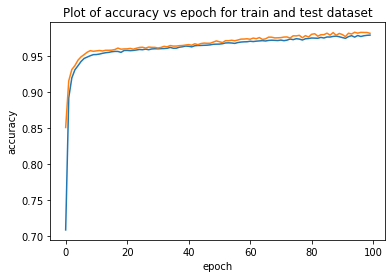

In [28]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

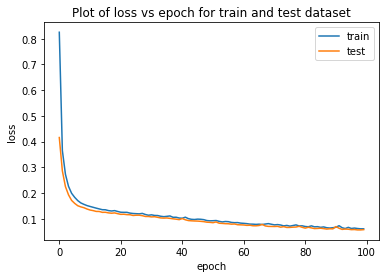

In [29]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()